In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from os.path import join
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

##1. 데이터 로드

In [3]:
# 데이터 불러오기
mod_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GitHub/AI-ExpertFW-Prj/dataset/modcloth.xlsx')
rent_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GitHub/AI-ExpertFW-Prj/dataset/renttherunway.xlsx')

rent_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [ ]:
# 리뷰 컬럼만 추출
mod_rv_df = mod_df[['item_id', 'user_id', 'category', 'quality', 'review_summary', 'review_text']]
rent_rv_df = rent_df[['item_id', 'user_id', 'category', 'rating', 'review_summary', 'review_text']]

# 컬럼명 변경
mod_rv_df.rename(columns = {'quality':'rating'}, inplace = True)

# 평가 컬럼 기준을 맞춰줌
rent_rv_df[['rating']] = rent_rv_df[['rating']]/2

# 리뷰 데이터 셋 합치기
rv_df = pd.concat([mod_rv_df, rent_rv_df], ignore_index = True)

# 리뷰 summary + content
rv_df['review'] = rv_df['review_summary'] + " " + rv_df['review_text']

# 불필요한 문자 삭제
rv_df['review'] = rv_df['review'].str.replace("[^a-zA-Z' ]", "")

# 대문자 > 소문자
rv_df['review'] = rv_df['review'].str.lower()

# 긍정/부정 label 생성
rv_df.loc[rv_df['rating'] >= 4, 'label'] = "1"
rv_df.loc[rv_df['rating'] < 3, 'label'] = "0"

# 카테고리 정리
rv_df.replace({'category':['dresses', 'dress', 'shirtdress']}, 'dress', inplace = True)
rv_df.replace({'category':['tops', 'top']}, 'tops', inplace = True)
rv_df.replace({'category':['bottoms', 'sweatpants', 'jeans', 'down']}, 'bottoms', inplace = True)
rv_df.replace({'category':['leggings', 'legging']}, 'leggings', inplace = True)
rv_df.replace({'category':['shirt', 't-shirt','sweatershirt', 'sweatshirt']}, 'shirts', inplace = True)
rv_df.replace({'category':['skirt', 'skirts']}, 'skirts', inplace = True)
rv_df.replace({'category':['coat', 'peacoat', 'overcoat']}, 'coats', inplace = True)

# 결측 행 제거
rv_df2 = rv_df.dropna(how = 'any')    # 239,500개

##2. 데이터 파티셔닝

In [ ]:
print( rv_df2['label'].value_counts( ) )

In [33]:
rv_df_posi = rv_df2[(rv_df2['label'] == '1')].sample(frac = 0.1, random_state = 1004)
rv_df_nega = rv_df2[(rv_df2['label'] == '0')]

In [34]:
rv_df3 = pd.concat([rv_df_posi, rv_df_nega], ignore_index=True)

In [35]:
len(rv_df3)

32712

In [37]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(rv_df3, test_size=0.2)

##3. tokenization

In [ ]:
# 진행 상태를 알려주는 기능
!pip install tqdm
from tqdm import tqdm

# 영어 형태소 분석
import nltk
import pickle
from nltk.corpus import stopwords
import re

nltk.download('all')

# 단어 원형으로 steaming
wlem = nltk.WordNetLemmatizer()

# stop word 정의
stop_words = stopwords.words('english')
stop_words.extend(['dress', 'heels', 'i', 'it', 'im', 'so', 'review', 'tt', 'aa', 'r', ''])

def nltk_token(sentence) :
    token_list = []
    word_tokens = nltk.word_tokenize(sentence)
    token_pos = nltk.pos_tag(word_tokens)                 # 품사를 분리한다.
    for word, pos in token_pos :
        new_word = wlem.lemmatize(word)                   # 단어 원형을 뽑는다.
        if 'NN' in pos and not new_word in stop_words :   # 불용어를 제외한 명사만 뽑는다.
            token_list.append(new_word)

    return token_list

##4. TF-IDF (DTM 생성)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 객체 생성
tfidf_vect = TfidfVectorizer(tokenizer = nltk_token, min_df = 10)

# 각 리뷰 벡터화
tfidf_vect.fit(tqdm(train_df['review']))

  0%|          | 0/26169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
100%|██████████| 26169/26169 [02:32<00:00, 172.16it/s]


TfidfVectorizer(min_df=10, tokenizer=<function nltk_token at 0x7f25d68aab00>)

In [42]:
# DTM 생성
tfidf_matrix_train = tfidf_vect.transform(train_df['review'])
tfidf_matrix_test = tfidf_vect.transform(test_df['review'])

In [ ]:
tfidf_vect.vocabulary_.keys()

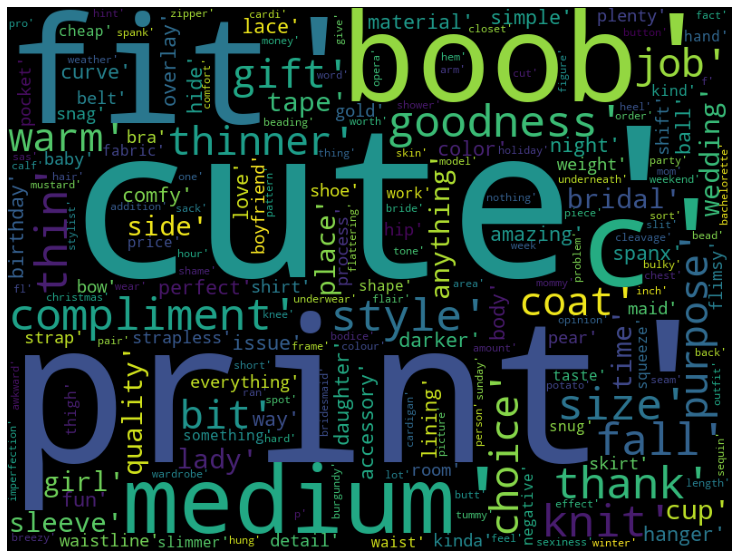

In [41]:
# 워드클라우드
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = str( list( tfidf_vect.vocabulary_.keys() ) )
words

wordcloud = WordCloud(background_color = "black", width = 800, height = 600).generate(words)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# 카테고리 별 워드 클라우드






In [ ]:
# 진행 상태를 알려주는 기능
!pip install tqdm
from tqdm import tqdm

# 영어 형태소 분석
import nltk
import pickle
from nltk.corpus import stopwords
import re

nltk.download('all')

# 단어 원형으로 steaming
wlem = nltk.WordNetLemmatizer()

# stop word 정의
stop_words = stopwords.words('english')
stop_words.extend(['dress', 'heels', 'i', 'it', 'im', 'so', 'review', 'tt', 'aa', 'r', ''])

def nltk_token(sentence) :
    token_list = []
    word_tokens = nltk.word_tokenize(sentence)
    token_pos = nltk.pos_tag(word_tokens)                 # 품사를 분리한다.
    for word, pos in token_pos :
        new_word = wlem.lemmatize(word)                   # 단어 원형을 뽑는다.
        if 'NN' in pos and not new_word in stop_words :   # 불용어를 제외한 명사만 뽑는다.
            token_list.append(new_word)

    return token_list

In [ ]:
# 각 리뷰 벡터화
tfidf_vect.fit(tqdm(train_df['review']))

  0%|          | 0/26169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
100%|██████████| 26169/26169 [02:32<00:00, 172.16it/s]


TfidfVectorizer(min_df=10, tokenizer=<function nltk_token at 0x7f25d68aab00>)

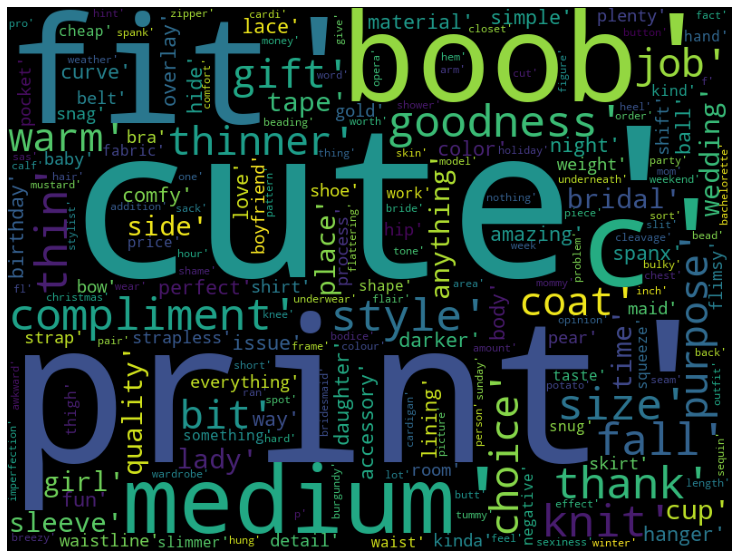

In [ ]:
# 워드클라우드
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = str( list( tfidf_vect.vocabulary_.keys() ) )
words

wordcloud = WordCloud(background_color = "black", width = 800, height = 600).generate(words)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##5. 모델링

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# RandomForest
rf = RandomForestClassifier(random_state = 0, n_estimators=1000)
rf.fit(tfidf_matrix_train , train_df['label'])              
preds1 = rf.predict(tfidf_matrix_test)                          
print('RF Accuracy: ',accuracy_score(test_df['label'],preds1))  

# Decision Tree
dt1 = tree.DecisionTreeClassifier()
dt1 = dt1.fit(tfidf_matrix_train , train_df['label'])
dt1.feature_importances_
preds2 = dt1.predict( tfidf_matrix_test )
print('DT Accuracy: ',accuracy_score(test_df['label'],preds2))

# Naive Bayes
clf = MultinomialNB().fit(tfidf_matrix_train , train_df['label'])
preds3 = clf.predict(tfidf_matrix_test)
print('NB Accuracy: ',accuracy_score(test_df['label'],preds3))

# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(tfidf_matrix_train , train_df['label'])
preds4 = lr_clf.predict(tfidf_matrix_test)
print('LR Accuracy: ',accuracy_score(test_df['label'],preds4))

RF Accuracy:  0.8146110346935657
DT Accuracy:  0.752254317591319
NB Accuracy:  0.8016200519639309
LR Accuracy:  0.8233226348769678


In [88]:
# DNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

# OHE
y = to_categorical(train_df['label'])       # target
x = np.array(tfidf_matrix_test.todense())         # sparse 형태라 변경해줘야함

# partitioning
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

ValueError: ignored

In [62]:
tfidf_matrix_test.shape

(47900, 4514)

In [ ]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (47900, ) ) )
model.add(Dense(2, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
13/13 [==============================] - 1s 5ms/step - loss: 0.6508 - acc: 0.7175
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 0.4910 - acc: 0.9575
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 0.3692 - acc: 0.9575
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 0.2785 - acc: 0.9575
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.2240 - acc: 0.9575
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.1922 - acc: 0.9575
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.1794 - acc: 0.9575
Epoch 8/10
13/13 [==============================] - 0s 3ms/step - loss: 0.1714 - acc: 0.9575
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 0.1668 - acc: 0.9575
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 0.1627 - acc: 0.9575


In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0881 - acc: 0.9900


[0.08814475685358047, 0.9900000095367432]

In [ ]:
pred = np.argmax(model.predict(X_test), axis = 1)    # 예측값
actual = np.argmax(y_test, axis = 1)                 # 실제값

print(classification_report(pred, actual))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99       100

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##6. 유사도 분석

In [45]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

In [46]:
def nltk_tokenizer(_wd):
  return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [47]:
rv_df3['Token_review'] = rv_df3['review'].apply(nltk_tokenizer)

KeyboardInterrupt: ignored

In [67]:
# stop word
stop_words = stopwords.words('english')
stop_words.extend(['dress', 'heels', 'i', 'it', 'im', 'so', 'review', 'tt', 'aa', 'r'])

tokenized_data = []

for array in tqdm(rv_df3['review']) :  
    temp = []
    word_tokens = nltk.word_tokenize(array) 
    token_pos = nltk.pos_tag(word_tokens)            
    for word, pos in token_pos :
       if 'NN' in pos and not word in stop_words :   
           temp.append(word)
    tokenized_data.append(temp)

100%|██████████| 32712/32712 [02:14<00:00, 242.47it/s]


In [69]:
# Word2Vec
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 10, 
                 window = 5, 
                 min_count = 2, 
                 workers = 4, sg = 0)

In [ ]:
model.wv.vocab.keys()

In [75]:
print(model.wv.most_similar('morning'))

[('pickup', 0.9965230226516724), ('semi', 0.9926567673683167), ('adult', 0.989936113357544), ('ambassador', 0.9893835186958313), ('rockstar', 0.9892721176147461), ('lipstick', 0.989263117313385), ('grabber', 0.9890927076339722), ('mildew', 0.9890090823173523), ('roy', 0.9889833331108093), ('casino', 0.9886914491653442)]


In [77]:
model.wv.vectors[0]

array([ 0.7387779 , -0.25450668, -0.12468334, -0.2705094 , -2.7576938 ,
        0.47901833,  1.7066085 , -1.0545346 ,  3.5152628 , -0.86598784],
      dtype=float32)

In [85]:
df = pd.DataFrame(model.wv.vectors)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/AI-ExpertFW-Prj/dataset/wv_model_tsv.tsv', sep = '\t', index = False)

In [86]:
word_df = pd.DataFrame(model.wv.index2word)
word_df.to_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/AI-ExpertFW-Prj/dataset/wv_word_tsv.tsv', sep = '\t', index = False)

In [78]:
tagged_data = [ TaggedDocument(words = tokenized_data[i], tags=[i]) for i in range(len(tokenized_data))]
len(tagged_data)

32712

In [79]:
# Doc2Vec
model = Doc2Vec(
    epochs = 40,
    window = 5,
    vector_size = 10,  # 컬럼 수
    min_count = 2,     # 최소 단어 빈도를 2
    dm = 1)            # pv-dm: 1, pv-dbow:2
  
model.build_vocab(tagged_data)

In [80]:
model.docvecs.vectors_docs

array([[-2.8973157e-02,  2.9773481e-02,  4.7597256e-02, ...,
         7.1201022e-03,  1.9758267e-02,  2.2557310e-03],
       [-4.9297169e-02,  5.8319159e-03, -9.8851267e-03, ...,
         1.1129258e-02,  3.6699191e-02,  1.5059315e-02],
       [ 3.7610475e-02,  4.9170680e-02, -4.6764813e-02, ...,
        -3.1095888e-02, -2.5378990e-03, -1.1652588e-02],
       ...,
       [ 1.3957312e-02, -2.3065532e-02, -5.4059132e-05, ...,
        -3.4447677e-02, -2.9167043e-02,  2.5727132e-02],
       [-1.1765298e-02,  4.2956620e-02, -3.9973240e-02, ...,
         1.5361905e-02,  9.1882031e-03,  2.5638511e-02],
       [-4.4992227e-02, -9.6250242e-03,  4.4225626e-02, ...,
         5.2532549e-03, -4.0269926e-02, -3.2332312e-02]], dtype=float32)

In [81]:
doc_list = 'this dress is very fashionable so i like it'.split(' ')
doc_list

['this', 'dress', 'is', 'very', 'fashionable', 'so', 'i', 'like', 'it']

In [82]:
inferred_vector = model.infer_vector(doc_list)
inferred_vector

array([ 0.04598914,  0.04448592,  0.01119065, -0.00541281, -0.00614594,
        0.00343054, -0.03885478,  0.00347427,  0.02868306,  0.00087597],
      dtype=float32)

In [83]:
# 유사한 document 5개 추출
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn = 5)
return_docs

[(2807, 0.9238296151161194),
 (32254, 0.9120063781738281),
 (16056, 0.9016774892807007),
 (8763, 0.8974917531013489),
 (17297, 0.8898831009864807)]

## item 별 DOC 를 만들어 리뷰가 유사한 상품 추출

In [89]:
def nltk_tokenizer(_wd):
  return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [92]:
# review 문장을 단어로 쪼갠다.
def nltk_tokenizer(_wd):
  return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

rv_df3['Token_review'] = rv_df3['review'].apply(nltk_tokenizer)
rv_df3.head(100)

,item_id,user_id,category,rating,review_summary,review_text,review,label,Token_review
0,806919,349774,gown,5.0,Stand Out Dress!,I loved this dress and the fit! It was form f...,stand out dress i loved this dress and the fit...,1,"[stand, out, dress, i, loved, this, dress, and..."
1,655211,534552,bottoms,5.0,I really want to like thi,I really want to like this skirt more than I d...,i really want to like thi i really want to lik...,1,"[i, really, want, to, like, thi, i, really, wa..."
2,659083,488779,new,4.0,Darn I wish I had ordered,Darn I wish I had ordered a size larger becaus...,darn i wish i had ordered darn i wish i had or...,1,"[darn, i, wish, i, had, ordered, darn, i, wish..."
3,479018,870791,dress,5.0,Wore the dress to a rehearsal dinner and it wa...,Dress is form fitting and beautiful! It hugs i...,wore the dress to a rehearsal dinner and it wa...,1,"[wore, the, dress, to, a, rehearsal, dinner, a..."
4,497011,362951,gown,5.0,Stylist Review,This dress was so beautiful and was surprising...,stylist review this dress was so beautiful and...,1,"[stylist, review, this, dress, was, so, beauti..."
...,...,...,...,...,...,...,...,...,...
95,756784,191123,gown,5.0,This dress was perfect for my event!,I am normally a size 4. I ordered the 4R and 6...,this dress was perfect for my event i am norma...,1,"[this, dress, was, perfect, for, my, event, i,..."
96,1167757,526458,dress,5.0,Loved it!,Great fit. Beautiful stitching. Could even b...,loved it great fit beautiful stitching could...,1,"[loved, it, great, fit, beautiful, stitching, ..."
97,933074,416932,dress,5.0,Perfect for a summer wedding!,This dress ran a little large so I went with t...,perfect for a summer wedding this dress ran a ...,1,"[perfect, for, a, summer, wedding, this, dress..."
98,126335,584788,dress,4.0,"loved the dress, perfect for a wedding!",Loved this dress! Everyone commented on how fu...,loved the dress perfect for a wedding loved th...,1,"[loved, the, dress, perfect, for, a, wedding, ..."


In [93]:
# item_id 와 tokenized 된 review만 뽑음
doc_item_text_df = rv_df3[['item_id', 'Token_review']].values.tolist()

tagged_data = [TaggedDocument(words=_d, tags=[str(uid)]) for uid, _d in doc_item_text_df]
tagged_data[0]

TaggedDocument(words=['stand', 'out', 'dress', 'i', 'loved', 'this', 'dress', 'and', 'the', 'fit', 'it', 'was', 'form', 'fitting', 'and', 'long', 'enough', 'for', 'my', 'ft', 'frame', 'the', 'slit', 'also', 'made', 'it', 'not', 'just', 'a', 'plain', 'red', 'dress', 'i', 'recommend', 'to', 'anyone'], tags=['806919'])

In [ ]:
?Doc2Vec
#https://jhnoru.tistory.com/163   :   Doc2Vec 파라메터 설명
#https://frhyme.github.io/python-libs/nlp_doc2vec_gensim/
#https://roboreport.co.kr/doc2vec-%ED%9B%88%EB%A0%A8-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%84%A4%EB%AA%85/

# store the model to mmap-able files
#model.save('/tmp/my_model.doc2vec')
# load the model back
#model_loaded = Doc2Vec.load('/tmp/my_model.doc2vec')

In [94]:
max_epochs = 10

model = Doc2Vec(
    window=10,
    size=100,
    alpha=0.025, 
    min_alpha=0.025,
    min_count=2,
    dm =1,  #pv-dm: 1, pv-dbow:2
    negative = 5,
    seed = 9999)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs) : 
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

#model.save('item_review_text_model.doc2vec')# 모델 저장함 
#model = Doc2Vec.load('item_review_text_model.doc2vec')#모델 불러올 때 사용

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [ ]:
#model.save('item_review_text_model.doc2vec')
# load the model back
#model_loaded = Doc2Vec.load('/tmp/my_model.doc2vec')

In [95]:
model.random.seed(9999)

doc_list = 'Great fit'.split(' ')

inferred_vector = model.infer_vector(tagged_data[0].words)
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn = 5)

for rd in return_docs:
  for des in rv_df3[rv_df3['item_id'] == rd[0]]['review_text']:
    print(rd[0],rd[1],des)

In [98]:
return_docs = model.docvecs.most_similar(500, topn = 5)

for rd in return_docs:
  for des in rv_df3[rv_df3['item_id'] == rd[0]]['item_id']:
    print(rd[0],rd[1],des)

In [ ]:
len(model.docvecs)

533

In [99]:
len(model.docvecs.offset2doctag)

4908

In [100]:
len(model.docvecs.vectors_docs)

4908

In [ ]:


# tokenized_data = []

# # 단어 원형으로 steaming
# wlem = nltk.WordNetLemmatizer()

# for array in tqdm(rv_df2['tokenized'][:1000]) :   #[:500]
#     token_pos = nltk.pos_tag(word_tokens)             # 품사를 분리한다.
#     for word, pos in token_pos :
#         new_word = wlem.lemmatize(word)
#         if 'NN' in pos and not new_word in stop_words :   # 불용어를 제외한 명사만 뽑는다.
#             tokenized_data.append(new_word)

# print(tokenized_data)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]

['ruching', 'color', 'silhouette', 'fabric', 'ruching', 'thing', 'size', 'suit', 'body', 'type', 'body', 'type', 'waist', 'flabby', 'tummy', 'detail', 'front', 'everything', 'clingyness', 'material', 'cling', 'bum', 'bum', 'jiggle', 'slit', 'office', 'appropriate', 'tights', 'tights', 'occasion', 'profession', 'look', 'work', 'wrap', 'portion', 'cut', 'breast', 'slit', 'back', 'someone', 'height', 'cheek', 'color', 'thickness', 'fabric', 'cut', 'cap', 'sleeve', 'size', 'legging', 'sale', 'lot', 'people', 'snug', 'length', 'color', 'work', 'super', 'flattering', 'flattering', 'shape', 'fabric', 'color', 'ruching', 'front', 'husband', 'fabric', 'pill', 'time', 'quality', 'quality', 'bought', 'fit', 'pretty', 'color', 'length', 'fit', 'size', 'pound', 'ruching', 'waist', 'weight', 'tummy', 'job', 'bulk', 'ruching', 'shoulder', 'addition', 'polyester', 'bo', 'sale', 'ish', 'price', 'fall', 'knee', 'knee', 'work', 'love', 'material', 'body', 'shape', 'l', 'body', 'shape', 'look', 'thing', '

In [ ]:
# 중복 제거
words = []
for word in tqdm(tokenized_data):
    if word not in words:
        words.append(word)

str_words = str(words)

100%|██████████| 8707/8707 [00:00<00:00, 116031.29it/s]


In [ ]:
rv_df2

,item_id,category,rating,review_summary,review_text,label,review,tokenized
6725,152702,new,4.0,too much ruching,i liked the color the silhouette and the fabri...,1,too much ruching i liked the color the silhoue...,NaN
6726,152702,new,5.0,suits my body type,from the other reviews it seems like this dres...,1,suits my body type from the other reviews it s...,NaN
6729,152702,new,5.0,this is a very profession,this is a very professional look it is great f...,1,this is a very profession this is a very profe...,NaN
6730,152702,new,4.0,im simply too tall for t,im simply too tall for this the wrap portion c...,1,im simply too tall for t im simply too tall fo...,NaN
6731,152702,new,4.0,i snagged this dress when,i snagged this dress when it went on sale and ...,1,i snagged this dress when i snagged this dress...,NaN
...,...,...,...,...,...,...,...,...
275328,326784,dress,4.0,perfect rehearsal dinner for the not all white...,i wore this dress at my rehearsal dinner and i...,1,perfect rehearsal dinner for the not all white...,NaN
275329,2252812,jumpsuit,5.0,love it first item im thinking of buying,fit like a glove,1,love it first item im thinking of buying fit l...,NaN
275330,682043,dress,5.0,love it,the pattern contrast on this dress is really s...,1,love it the pattern contrast on this dress is ...,NaN
275332,126335,dress,5.0,loved this dress it was comfortable and photog...,this dress was perfection it looked incredibl...,1,loved this dress it was comfortable and photog...,NaN


- 워드클라우드

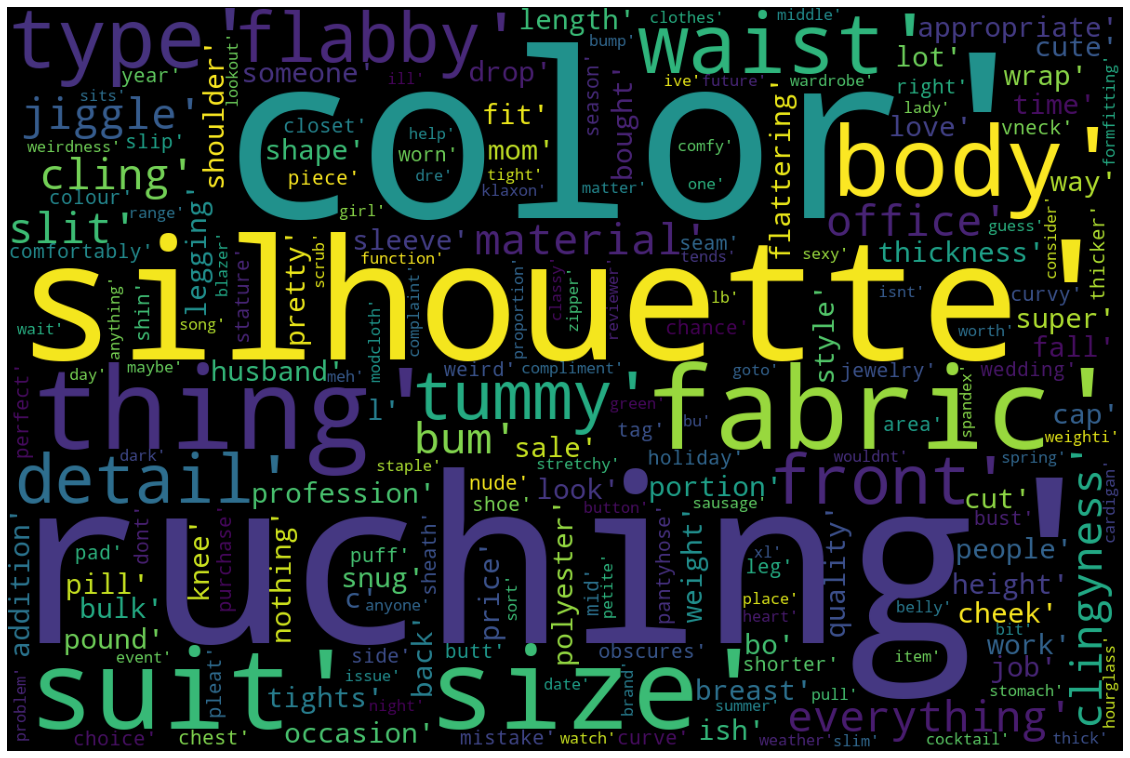

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud = WordCloud(background_color = "black", width = 1200, height = 800, max_words = 200).generate(str_words)
plt.figure(figsize = (20, 15))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [ ]:
# 빈도
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(words)

In [ ]:
tfidf_vect.vocabulary_

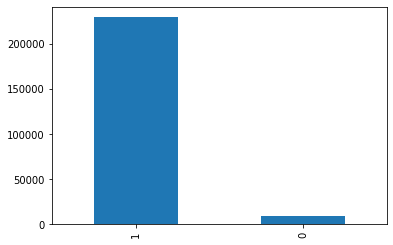

In [ ]:
rv_df2['label'].value_counts().plot(kind = 'bar')

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(rv_df2, test_size = 0.25, random_state = 33)

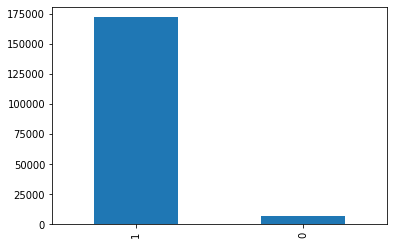

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
rv_df2['review'] = rv_df2['review'].str.replace("[^a-zA-Z ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_data

,item_id,user_id,category,rating,review_summary,review_text,review,label,tokenized
269061,2646149,793741,tunic,4.0,Great top!,I wore this top to dinner and a concert with h...,great top i wore this top to dinner and a conc...,1,"[concert, pant, skin, cute, bit, bust, c, coup..."
185685,124553,210364,dress,5.0,The color plus the asymmetric hem = dazzling!,Absolutely adore both this designer and this d...,the color plus the asymmetric hem dazzling ab...,1,"[color, hem, designer, eye, catching, man, col..."
54798,630114,865420,tops,5.0,I love the color and soft,I love the color and soft fabric !Easy to wear...,i love the color and soft i love the color and...,1,"[color, color, fabric, easy, clothes, tshirts]"
244063,127865,538484,gown,5.0,The dress was a perfect fit. I loved it so much,"I'm 5'4"" and I ordered the 10L just in case be...",the dress was a perfect fit i loved it so muc...,1,"[fit, l, case, heel, event]"
118116,1122460,952716,sheath,4.0,Great dress!,This was sent to me as a backup and I didn't e...,great dress this was sent to me as a backup an...,1,"[backup, flattering, fit]"
...,...,...,...,...,...,...,...,...,...
258720,765473,829246,gown,5.0,A beautiful night in NYC,"Lightweight, pockets, beautiful color & so str...",a beautiful night in nyc lightweight pockets ...,1,"[night, pocket, color, person]"
160832,295072,892326,dress,4.0,fun casual dress,this was a fun weekend dress and a nice change...,fun casual dress this was a fun weekend dress ...,1,"[fun, weekend, change, pace, jean, tee, friend..."
131635,135459,594840,dress,5.0,I felt gorgeous the whole evening!,"I'm at my ""fluffiest"" currently. I blame it on...",i felt gorgeous the whole evening im at my flu...,1,"[evening, winter, living, england, wedding, ad..."
232381,1347799,711548,dress,4.0,"Elegant, modern, but TIGHT in the chest for la...",I mistakenly perceived the fabric as a heavy t...,elegant modern but tight in the chest for larg...,1,"[chest, bust, fabric, twill, photo, lightweigh..."


In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 10, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, 
                 sg = 0)

In [ ]:
print(model.wv.most_similar("wow"))

[('rabbit', 0.9260751008987427), ('absolute', 0.9103262424468994), ('jessica', 0.8997465372085571), ('bombshell', 0.8925307989120483), ('knockout', 0.8820387125015259), ('everyones', 0.8761920928955078), ('premiere', 0.8520156145095825), ('confidence', 0.850999116897583), ('vavavoom', 0.8490220904350281), ('dollar', 0.8472979068756104)]


In [ ]:
model.wv.vectors[0]
model.wv.vocab

{'ruching': <gensim.models.keyedvectors.Vocab at 0x7ff8acae2c50>,
 'color': <gensim.models.keyedvectors.Vocab at 0x7ff8acae0910>,
 'silhouette': <gensim.models.keyedvectors.Vocab at 0x7ff8acae0710>,
 'fabric': <gensim.models.keyedvectors.Vocab at 0x7ff8acae0ad0>,
 'thing': <gensim.models.keyedvectors.Vocab at 0x7ff8aca87b50>,
 'size': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112550>,
 'suit': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112150>,
 'body': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112f50>,
 'type': <gensim.models.keyedvectors.Vocab at 0x7ff8aca87ad0>,
 'waist': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112f10>,
 'flabby': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112bd0>,
 'tummy': <gensim.models.keyedvectors.Vocab at 0x7ff8eb1125d0>,
 'detail': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112490>,
 'front': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112cd0>,
 'everything': <gensim.models.keyedvectors.Vocab at 0x7ff8eb112350>,
 'clingyness': <gensim.models

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [ TaggedDocument(words = tokenized_data[i], tags=[i]) for i in range(len(tokenized_data))]
len(tagged_data)

239500

In [ ]:
model = Doc2Vec(
    epochs=40,
    window=5,
    vector_size=100,  # 얻고자 하는 컬럼의 수, 한 문서를 몇개의 값의 좌표로 표현,
    min_count=2,  #최소 단어 빈도를 2
    dm =1)  #pv-dm: 1, pv-dbow:2
  
model.build_vocab(tagged_data)

In [ ]:
model.docvecs.vectors_docs.shape

(239500, 100)

In [ ]:
rv_df2.label.shape

(239500,)

In [ ]:
df2 = pd.concat([pd.DataFrame(model.docvecs.vectors_docs), rv_df2.label], axis = 1)

In [ ]:
df2['label'].value_counts()

1    229764
0      9736
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size = 0.2)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=0, n_estimators=300)  
rf.fit(train.drop(['label'], axis = 1) , train['label']) 
pred = rf.predict(test.drop(['label'], axis = 1))
print('Accuracy: ', accuracy_score(test['label'], pred))

ValueError: ignored

In [ ]:
inferred_vector = model.infer_vector(doc_list)
inferred_vector

array([ 0.01030281, -0.01926916,  0.01172422, -0.03636693, -0.04719078,
        0.04167508,  0.03322514,  0.01318205,  0.01699528, -0.02598334],
      dtype=float32)

- 유사한 document 발견

In [ ]:
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=10)
return_docs

[(348, 0.9006552696228027),
 (150, 0.8507030010223389),
 (905, 0.8207045793533325),
 (251, 0.8076239824295044),
 (63, 0.8018085956573486),
 (913, 0.7856948375701904),
 (175, 0.7799313068389893),
 (324, 0.7594480514526367),
 (944, 0.7555750608444214),
 (721, 0.7281869053840637)]

In [ ]:
return_docs = model.docvecs.most_similar(348,topn=3)
return_docs

[(913, 0.8800613880157471),
 (324, 0.8783514499664307),
 (166, 0.8176919221878052)]

5. LDA 적용

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_data) #사전 구성
corpus = [dictionary.doc2bow(text) for text in tokenized_data]  

import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, passes=15)

#각 토픽의 출현확률이 높은 단어를 지정된 갯수만큼 반환
topics = ldamodel.print_topics(num_words=20)

#위 내용을 출력
for topic in topics:
    print(topic)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

(0, '0.018*"중국" + 0.013*"봉쇄" + 0.010*"상하이" + 0.010*"수" + 0.008*"생산" + 0.008*"공장" + 0.007*"애플" + 0.007*"일" + 0.006*"코로나" + 0.005*"디지털" + 0.005*"세계" + 0.004*"앱" + 0.004*"말" + 0.004*"기업" + 0.004*"정부" + 0.004*"서비스" + 0.004*"월" + 0.003*"지역" + 0.003*"제품" + 0.003*"지원"')
(1, '0.027*"애플" + 0.015*"전자" + 0.013*"스마트폰" + 0.011*"갤럭시" + 0.011*"시장" + 0.010*"카메라" + 0.009*"중국" + 0.008*"제품" + 0.007*"업체" + 0.007*"수" + 0.006*"생산" + 0.006*"출시" + 0.006*"삼성" + 0.006*"반도체" + 0.005*"분기" + 0.005*"지난해" + 0.005*"국내" + 0.005*"매출" + 0.005*"시리즈" + 0.005*"중"')
(2, '0.017*"검사" + 0.011*"아이팟" + 0.010*"검찰" + 0.010*"사건" + 0.009*"검" + 0.008*"후보자" + 0.007*"수사" + 0.007*"장관" + 0.007*"처분" + 0.006*"윤" + 0.006*"의혹" + 0.005*"대통령" + 0.005*"전" + 0.005*"무혐의" + 0.005*"월" + 0.005*"일" + 0.005*"수" + 0.005*"중앙" + 0.004*"서울" + 0.004*"음악"')
(3, '0.011*"수" + 0.008*"금융" + 0.007*"앱" + 0.006*"교육" + 0.006*"실적" + 0.005*"일" + 0.005*"애플" + 0.005*"증권" + 0.005*"분기" + 0.004*"제공" + 0.004*"미국" + 0.004*"영업" + 0.004*"삼성" + 0.004*"니모" + 0.004*"서비스" + 0.004

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

6. LDA 시각화

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

7. LDA의 토픽 개수 탐색

In [ ]:
from gensim.models.ldamodel import LdaModel 
from gensim.models.coherencemodel import CoherenceModel 

coherence_values = [] 
model_list = [] 
iters = [8, 9,10, 11, 12]

for num_topics in iters: 
     model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
     model_list.append(model) 
     coherencemodel = CoherenceModel(model=model, texts=tokenized_data, dictionary=dictionary, coherence='c_v') 
     coherence_values.append(coherencemodel.get_coherence()) 

for i in range(0, len(iters)):
  print(model_list[i], coherence_values[i])  #topic num별로 coherence 가 높은 것을 찾기

# 감성분석